# Notebook containing the figures

In [275]:
import torch
import matplotlib.pyplot as plt 
import os
import datetime
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
import json
FOLDER = 'figures'
SIMULATION_FOLDER = 'simulations'
GRAPHS_ID = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
graph_folder = os.path.join(FOLDER, GRAPHS_ID)
os.makedirs(graph_folder, exist_ok=True)

## Functions used for positive and negative updates

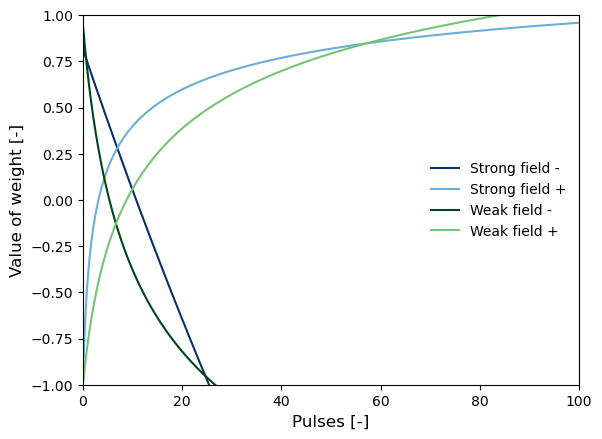

In [276]:
scale = 1
f_strong_minus = lambda x: scale * (2*(-24.77 * \
                torch.log(0.287*torch.log(x+128))+9.11)-1)
f_strong_plus = lambda x: scale * (2*(0.443 * \
                torch.log(2.53*torch.log(x+1.66)) - 0.11)-1)

f_weak_minus = lambda x: scale * \
                (-2.56*torch.log(0.997*torch.log(x+5.02)) + 2.166)
f_weak_plus = lambda x: scale * \
                (1.8132 * torch.log(1.176*torch.log(x+4.42))-2.014)
# plot all functions
fig, ax = plt.subplots()
x = torch.linspace(0, 100, 1000)
shades_blue = plt.get_cmap('Blues_r', 3)
shades_green = plt.get_cmap('Greens_r', 3)
ax.plot(x, f_strong_minus(x), label="Strong field -", color=shades_blue(0))
ax.plot(x, f_strong_plus(x), label="Strong field +", color=shades_blue(1))
ax.plot(x, f_weak_minus(x), label="Weak field -", color=shades_green(0))
ax.plot(x, f_weak_plus(x), label="Weak field +", color=shades_green(1))
ax.legend(loc='center right', fontsize=10, frameon=False)
ax.set_xlabel("Pulses [-]", fontsize=12)
ax.set_ylabel("Value of weight [-]", fontsize=12)
# export
name = "weight-evolution-" + GRAPHS_ID
ax.set_ylim(-scale, scale)
ax.set_xlim(0, 100)
fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')

## Load dataframe from simulation

In [277]:
n_iterations = 10
# Create a pandas dataframe with columns type, mean, std, learning rate
df = pd.DataFrame()
# get all paths
paths = [f for f in os.listdir(SIMULATION_FOLDER) if os.path.isdir(os.path.join(SIMULATION_FOLDER, f))]
for path in paths:
    try:
        # first dim of the tensor is the iteration
        accuracies = []
        mean_abs_grad = []
        swap = []
        weights = ""
        for it in range(n_iterations):
            jfile = path+f"-{it}.json"
            current_folder = os.path.join(SIMULATION_FOLDER, path)
            accuracies.append(torch.load(os.path.join(current_folder, path+f"-{it}-accuracies.pth")))
            mean_abs_grad.append(torch.load(os.path.join(current_folder, path+f"-{it}-gradients.pth")))
            swap_dict = json.load(open(os.path.join(current_folder, jfile), "r"))
            swap.append(swap_dict["swap_accuracy"])
            if it == 0:
                weights = path+f"-{it}-weights.pth"
                parameters = json.load(open(os.path.join(current_folder, jfile), "r"))
        accuracies = torch.stack(accuracies)    
        mean = accuracies.mean(dim=0)[-1].item()*100
        std = accuracies.std(dim=0)[-1].item()*100
        mean_abs_grad = torch.stack(mean_abs_grad).mean(dim=0)[0].item()
        swap_mean = torch.tensor(swap).mean().item()
        swap_std = torch.tensor(swap).std().item()
        # print parameters but well formatted
        task = parameters["task"]
        n_devices = parameters["optimizer_parameters"]["field"][0].split("-")[0]
        type_devices = parameters["optimizer_parameters"]["field"][0].split("-")[1]
        learning_rate = float(parameters["optimizer_parameters"]["lr"])
        scale = parameters["optimizer_parameters"]["scale"]
        resistor_noise = parameters["resistor_noise"]
        voltage_noise = parameters["voltage_noise"]
        var = parameters["optimizer_parameters"]["device_variability"]
        clipping = parameters["optimizer_parameters"]["clipping"]
        input_scale = parameters["input_scale"]
        df = df.append({"task": task,
                        "type_devices": type_devices,
                        "n_devices": n_devices,
                        "learning_rate": learning_rate,
                        "weights_path": weights,
                        "mean": mean,
                        "std": std,
                        "scale": scale,
                        "resistor_noise": resistor_noise,
                        "voltage_noise": voltage_noise,
                        "mean_abs_grad": mean_abs_grad,
                        "var": var,
                        "clipping": clipping,
                        "input_scale": input_scale,
                        "swap_mean": swap_mean,
                        "swap_std": swap_std}, ignore_index=True)
    except Exception as e:
        print(e)
        pass
df

,clipping,input_scale,learning_rate,mean,mean_abs_grad,n_devices,resistor_noise,scale,std,swap_mean,swap_std,task,type_devices,var,voltage_noise,weights_path
0,0.1,0.001,500.0,95.337999,0.014465,double,0.015,1.0,0.129427,95.173996,0.127907,MNIST,linear,0.2,0.000002,20240725163936-MNIST-double-linear-500.0-var-0...
1,0.1,0.001,1000.0,96.316004,0.032406,double,0.015,1.0,0.081676,95.991997,0.121910,MNIST,linear,0.2,0.000002,20240725164158-MNIST-double-linear-1000.0-var-...
2,0.1,0.001,2000.0,96.337003,0.054718,double,0.015,1.0,0.117477,95.671997,0.131303,MNIST,linear,0.2,0.000002,20240725164424-MNIST-double-linear-2000.0-var-...
3,0.1,0.001,3000.0,96.178997,0.073349,double,0.015,1.0,0.133371,95.278000,0.155692,MNIST,linear,0.2,0.000002,20240725164850-MNIST-double-linear-3000.0-var-...
4,0.1,0.001,4000.0,95.936996,0.090911,double,0.015,1.0,0.125526,94.671005,0.251105,MNIST,linear,0.2,0.000002,20240725165109-MNIST-double-linear-4000.0-var-...
5,0.1,0.001,5000.0,95.603001,0.107985,double,0.015,1.0,0.111559,93.981003,0.246824,MNIST,linear,0.2,0.000002,20240725165325-MNIST-double-linear-5000.0-var-...
6,0.1,0.001,500.0,95.002002,0.013395,double,0.015,1.0,0.108710,9.739999,0.000001,MNIST,exponential,0.2,0.000002,20240725165544-MNIST-double-exponential-500.0-...
7,0.1,0.001,1000.0,95.033991,0.025975,double,0.015,1.0,0.087203,10.626999,2.804940,MNIST,exponential,0.2,0.000002,20240725165830-MNIST-double-exponential-1000.0...
8,0.1,0.001,2000.0,93.789005,0.047124,double,0.015,1.0,0.140906,10.902999,2.870099,MNIST,exponential,0.2,0.000002,20240725170650-MNIST-double-exponential-2000.0...
9,0.1,0.001,3000.0,91.973001,0.065775,double,0.015,1.0,0.177329,9.829999,0.191833,MNIST,exponential,0.2,0.000002,20240725170927-MNIST-double-exponential-3000.0...


## Accuracy vs learning rate

### Clipping 0.1 - Resistor_noise 0.015

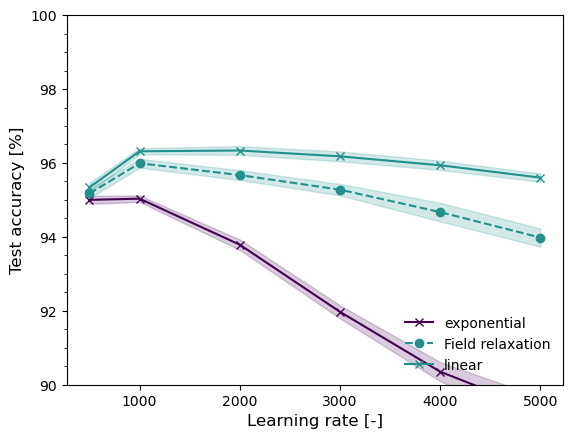

In [280]:
# for each task, plot the evolution of the accuracy
resistor_noise = 0.015
clipping = 0.1
var = 0.2
for task in df["task"].unique():
    df_filtered = df[(df["task"] == task) & (df["resistor_noise"] == resistor_noise) & (df["clipping"] == clipping) & (df["var"] == var)].sort_values("learning_rate")
    fig, ax = plt.subplots()
    palette = plt.get_cmap('viridis', len(df["type_devices"].unique())+1)
    for i, (name, group) in enumerate(df_filtered.groupby("type_devices")):  
        if name == "linear":
            ax.plot(group["learning_rate"], group["swap_mean"], label="Field relaxation" , color=palette(i), marker='o', linestyle='--')
            ax.fill_between(group["learning_rate"], group["swap_mean"]-group["swap_std"], group["swap_mean"]+group["swap_std"], alpha=0.2, color=palette(i))
        ax.plot(group["learning_rate"], group["mean"], label=name, color=palette(i), marker='x')
        ax.fill_between(group["learning_rate"], group["mean"]-group["std"], group["mean"]+group["std"], alpha=0.2, color=palette(i))
    ax.set_xlabel("Learning rate [-]", fontsize=12)
    ax.set_ylabel("Test accuracy [%]", fontsize=12)
    ax.legend(loc='lower right', fontsize=10, frameon=False)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    offset = 5
    minimum = 90 if task == "MNIST" else 80
    maximum = min(100, df_filtered["mean"].max() + offset)
    ax.set_ylim([minimum, maximum])
    ax.set_ylim([minimum, maximum])
    plt.show()
    # save as pdf and svg
    name = f"learning-rate-{task}-resistor_noise-{resistor_noise}-var-{var}-{GRAPHS_ID}"
    fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')

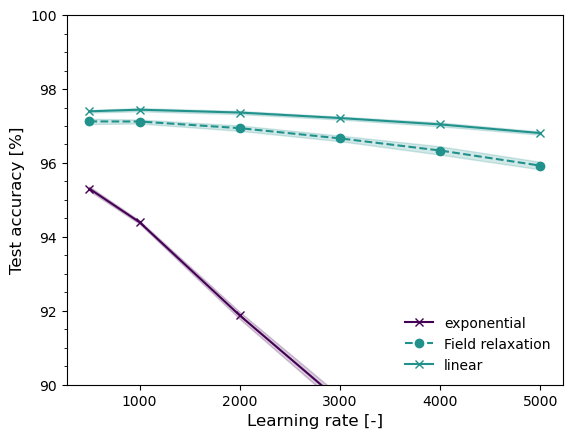

In [281]:
# for each task, plot the evolution of the accuracy
resistor_noise = 0.
clipping = 0
var = 0
for task in df["task"].unique():
    df_filtered = df[(df["task"] == task) & (df["resistor_noise"] == resistor_noise) & (df["clipping"] == clipping) & (df["var"] == var)].sort_values("learning_rate")
    fig, ax = plt.subplots()
    palette = plt.get_cmap('viridis', len(df["type_devices"].unique())+1)
    for i, (name, group) in enumerate(df_filtered.groupby("type_devices")):  
        if name == "linear":
            ax.plot(group["learning_rate"], group["swap_mean"], label="Field relaxation" , color=palette(i), marker='o', linestyle='--')
            ax.fill_between(group["learning_rate"], group["swap_mean"]-group["swap_std"], group["swap_mean"]+group["swap_std"], alpha=0.2, color=palette(i))
        ax.plot(group["learning_rate"], group["mean"], label=name, color=palette(i), marker='x')
        ax.fill_between(group["learning_rate"], group["mean"]-group["std"], group["mean"]+group["std"], alpha=0.2, color=palette(i))
    ax.set_xlabel("Learning rate [-]", fontsize=12)
    ax.set_ylabel("Test accuracy [%]", fontsize=12)
    ax.legend(loc='lower right', fontsize=10, frameon=False)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    offset = 5
    minimum = 90 if task == "MNIST" else 80
    maximum = min(100, df_filtered["mean"].max() + offset)
    ax.set_ylim([minimum, maximum])
    ax.set_ylim([minimum, maximum])
    plt.show()
    # save as pdf and svg
    name = f"learning-rate-{task}-resistor_noise-{resistor_noise}-var-{var}-{GRAPHS_ID}"
    fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')